In [1]:
using Plots

In [2]:
using Distributions

In [3]:
function simulate_realization(M, s1, s2)
    # Number of days
    days = 60
    
    # State
    # number of worn machines
    W = zeros(Int, days)
    # number of broken machines
    B = zeros(Int, days)
    
    # probability of new -> worn
    p12 = (1/60) + (1/200 - 1/60) * sqrt(1 - ((10 - s1) / 10)^2)
    # probability of worn -> broken
    p23 = (1/30) + (1/100 - 1/30) * sqrt(1 - ((10 - s2) / 10)^2)
    
    # Simulate
    for i in 1:(days-1)
        B12 = rand(Binomial(M-W[i]-B[i], p12))
        B23 = rand(Binomial(W[i], p23))
        
        W[i+1] = W[i] + B12 - B23
        B[i+1] = B[i] +     + B23 - B[i]
    end
    
    N = M * ones(days) - W - B
    
    N, W, B
end

function simulate(M, s1, s2)
    gain = 0.0
    
    realizations = 10_000
    for _ in 1:realizations
        N, W, B = simulate_realization(M, s1, s2)
        gain += (M - B[end]) - 90 * B[end] - s1 - s2
    end
    
    return gain / realizations
end

# Total number of machines
M = 2_000

# Parameters
# money spent daily for maintainance of worn machines
s1 = 4
# money spent daily for maintainance of broken machines
s2 = 6
@time simulate(M, s1, s2)

  0.488772 seconds (751.47 k allocations: 67.999 MiB, 2.95% gc time)


1430.6594

In [4]:
X = []
y = []
@time for j=2:2:10, k=2:2:10
    gain = simulate(M, j, k)
    push!(X, [j, k])
    push!(y, [gain])
    println("($j, $k) = $(gain)")
end

(2, 2) = 1036.9055
(2, 4) = 1193.3365
(2, 6) = 1300.0633
(2, 8) = 1360.1526
(2, 10) = 1378.1635
(4, 2) = 1228.053
(4, 4) = 1347.9475
(4, 6) = 1432.3884
(4, 8) = 1478.2362
(4, 10) = 1497.3391
(6, 2) = 1353.5167
(6, 4) = 1446.5389
(6, 6) = 1515.3278
(6, 8) = 1561.1483
(6, 10) = 1570.1502
(8, 2) = 1416.791
(8, 4) = 1503.5433
(8, 6) = 1568.4829
(8, 8) = 1601.6908
(8, 10) = 1614.3145
(10, 2) = 1438.0415
(10, 4) = 1523.2013
(10, 6) = 1581.5889
(10, 8) = 1612.1032
(10, 10) = 1626.9382
  4.538758 seconds (1.51 M allocations: 824.714 MiB, 2.49% gc time)


---

In [5]:
X

25-element Array{Any,1}:
 [2, 2]
 [2, 4]
 [2, 6]
 [2, 8]
 [2, 10]
 [4, 2]
 [4, 4]
 [4, 6]
 [4, 8]
 [4, 10]
 [6, 2]
 [6, 4]
 [6, 6]
 [6, 8]
 [6, 10]
 [8, 2]
 [8, 4]
 [8, 6]
 [8, 8]
 [8, 10]
 [10, 2]
 [10, 4]
 [10, 6]
 [10, 8]
 [10, 10]

In [6]:
y

25-element Array{Any,1}:
 [1036.9055]
 [1193.3365]
 [1300.0633]
 [1360.1526]
 [1378.1635]
 [1228.053]
 [1347.9475]
 [1432.3884]
 [1478.2362]
 [1497.3391]
 [1353.5167]
 [1446.5389]
 [1515.3278]
 [1561.1483]
 [1570.1502]
 [1416.791]
 [1503.5433]
 [1568.4829]
 [1601.6908]
 [1614.3145]
 [1438.0415]
 [1523.2013]
 [1581.5889]
 [1612.1032]
 [1626.9382]

---

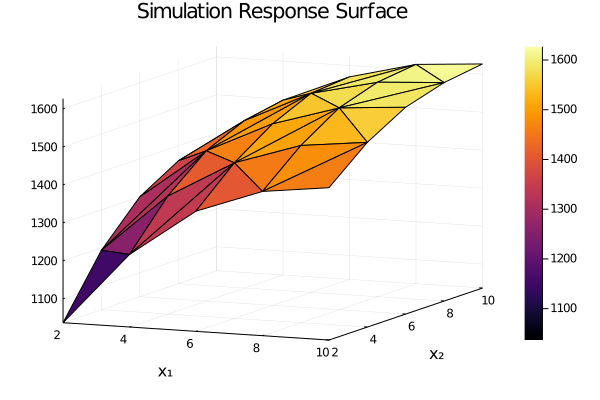

In [7]:
surface([x[1] for x in X], [x[2] for x in X], [y_[1] for y_ in y], title="Simulation Response Surface", xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

---

In [8]:
using Random

In [9]:
sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x) * (1 - sigma(x))

sigma_prime (generic function with 1 method)

In [10]:
using LinearAlgebra

In [11]:
function nn(x, W1, b1, W2, b2)
    z1 = W1 * x + b1
    a1 = sigma.(z1)
    z2 = W2 * a1 + b2
    a2 = z2
    return a2[1]
end

function compute_loss(W1, b1, W2, b2)
    loss = 0.0
    for (x, y_true) in zip(X, y)
        y_hat = nn(x, W1, b1, W2, b2)

        loss += (y_hat[1] - y_true[1])^2
    end
    loss /= (2 * size(X, 1))
    return loss
end

compute_loss (generic function with 1 method)

In [12]:
Random.seed!(1234);

mu = 1e-4

INPUT_SIZE = 2
HIDDEN_LAYER_SIZE = 100
W1 = randn(HIDDEN_LAYER_SIZE, INPUT_SIZE)
b1 = randn(HIDDEN_LAYER_SIZE, 1)

OUTPUT_LAYER_SIZE = 1
W2 = randn(OUTPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE)
b2 = randn(OUTPUT_LAYER_SIZE, 1)

for it in 1:1_000
    for (x, y_true) in zip(X, y)
        # Forward step to evaluate intermediate results
        z1 = W1 * x + b1
        a1 = sigma.(z1)
        z2 = W2 * a1 + b2
        a2 = z2

        # Backward step to evaluate parameter derivatives w.r.t. loss
        # d(loss)/d(z2) is `dz2`
        dz2 = a2 - y_true
        dW2 = dz2 * a1'
        db2 = dz2

        dz1 = (W2' * dz2) .* sigma_prime.(z1)
        dW1 = dz1 * x'
        db1 = dz1

        # Steepest descent to find optimal parameters
        W2 -= mu * dW2
        b2 -= mu * db2

        W1 -= mu * dW1
        b1 -= mu * db1
    end
    
    mu *= 0.9995
    
    if it % 200 == 0
        println("[$it]: $(round(compute_loss(W1, b1, W2, b2), digits=3))")
    end
end

[200]: 71.648
[400]: 3.476
[600]: 2.72
[800]: 2.432
[1000]: 2.129


---

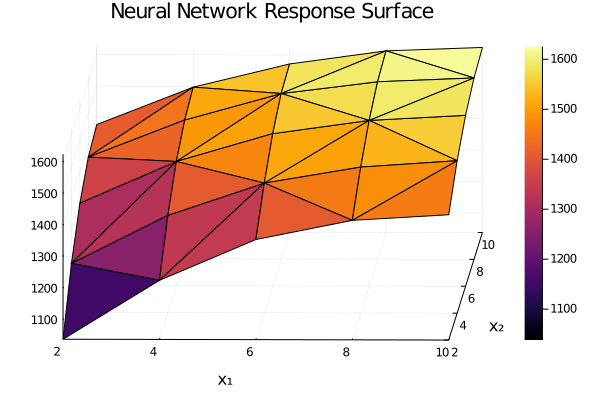

In [13]:
surface([x[1] for x in X], [x[2] for x in X], [nn(x, W1, b1, W2, b2) for (x,y) in zip(X,y)], camera=(5, 45), title="Neural Network Response Surface", xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

---

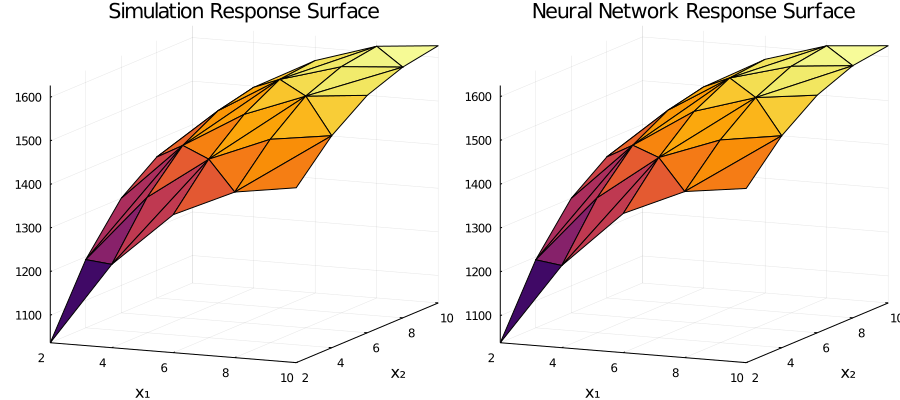

In [14]:
plot(
    surface([x[1] for x in X], [x[2] for x in X], [y_[1] for y_ in y], title="Simulation Response Surface", legend=false),
    surface([x[1] for x in X], [x[2] for x in X], [nn(x, W1, b1, W2, b2) for (x,y) in zip(X,y)], title="Neural Network Response Surface", legend=false),
    size=(900, 400),
    xlabel="x₁", ylabel="x₂"
)

---

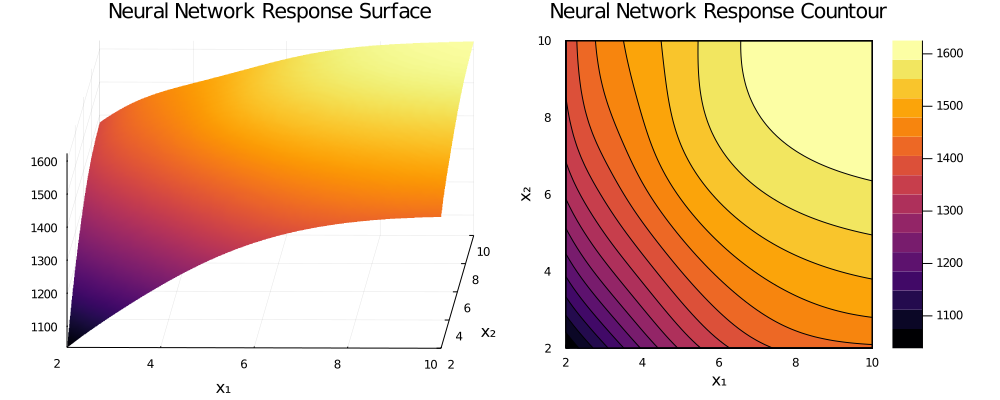

In [15]:
function plot_surface()
    plot(
        st=:surface,
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
        camera=(5,45),
        legend=false,
        title="Neural Network Response Surface"
    )
end

function plot_contour()
    contourf(
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
        title="Neural Network Response Countour"
    )
end
plot(plot_surface(), plot_contour(), size=(1000, 400), xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

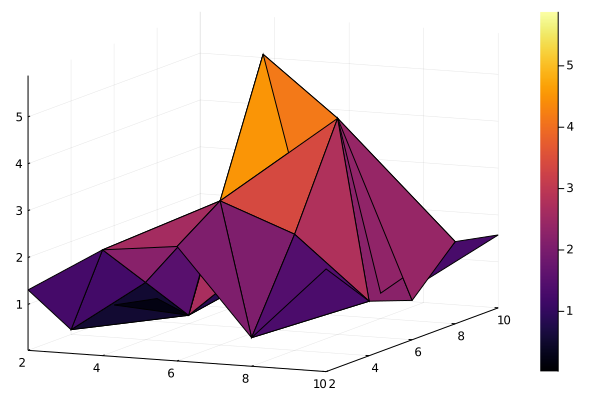

In [16]:
surface([x[1] for x in X], [x[2] for x in X], [abs(y[1]-nn(x, W1, b1, W2, b2)) for (x,y) in zip(X,y)])

In [17]:
for x in [[0.2, 0.5], [0.3, 0.9], [0.1, 0.9]]
    gain_nn = nn(x, W1, b1, W2, b2)
    gain_simulation = simulate(M, x[1], x[2])
    println("Gain NN: $(gain_nn), Gain Simulation: $(gain_simulation)")
end

Gain NN: 646.599931774028, Gain Simulation: 485.09639999990816
Gain NN: 701.1398297125917, Gain Simulation: 589.4920999998918
Gain NN: 666.279993283136, Gain Simulation: 505.3624


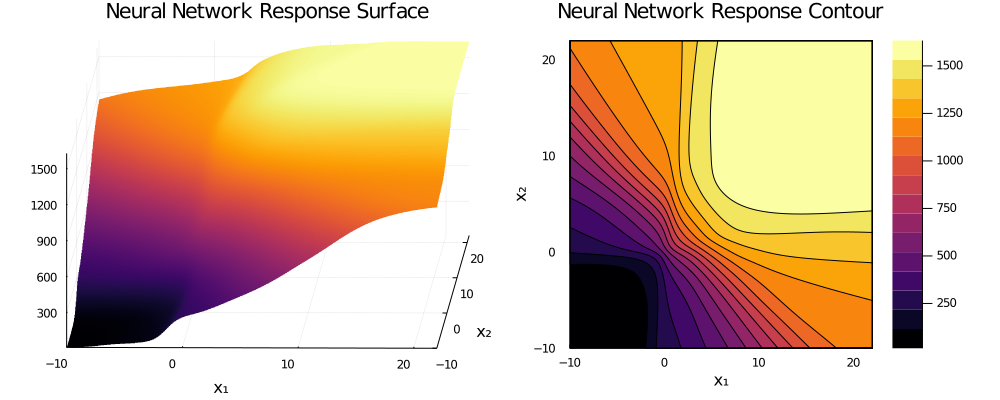

In [18]:
axis_range = -10:0.1:22
function plot_surface()
    plot(
        st=:surface,
        axis_range,
        axis_range,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
        camera=(5,45),
        title="Neural Network Response Surface",
        legend=false
    )
end

function plot_contour()
    contourf(
        axis_range,
        axis_range,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
        title="Neural Network Response Contour"
    )
end
plot(plot_surface(), plot_contour(), size=(1000, 400), xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

---

Ma perche' nel punto 1.2 devo usare uno stochastic gradient descent se il neural network e' una funzione deterministica??

In [19]:
max(y...)

1-element Array{Float64,1}:
 1626.9382

In [20]:
1.2^10

6.191736422399997

In [116]:
using LinearAlgebra

In [156]:
function maximize_gain()
    m = 1
    
    x = [rand(2:2:10), rand(2:2:10)]
    
    mu = 1
    
    C = 0.1
    
    trajectory = []
    
    while true
        h = rand([1, -1], size(x, 1))
        c = C / m^0.2
        
#             println("$(round.(x, digits=2)), $(round(nn(x, W1, b1, W2, b2), digits=0))")
#             println("c=$(round(c, digits=3))")
        
        if m % 1 == 0
            push!(trajectory, x)
        end
        
        finite_diff = nn(x + c*h, W1, b1, W2, b2) - nn(x - c*h, W1, b1, W2, b2)
        dx = [finite_diff / 2*c*h[i] for i in 1:size(x, 1)]

        x_new = x + mu * dx
        
        if norm(x - x_new) < 1e-3
            break
        end
        
        x = x_new
        
        m += 1
    end
    
    return trajectory
end
maximize_gain()
nothing

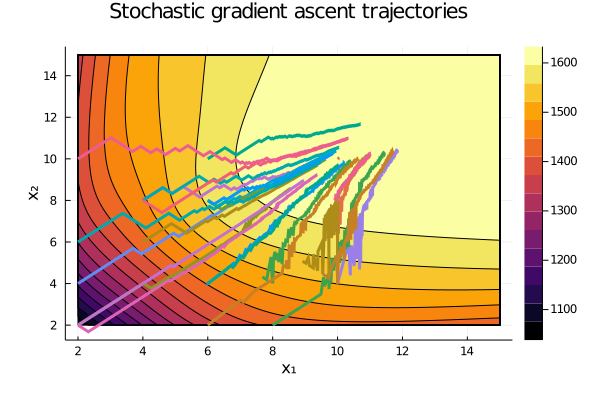

In [159]:
p = contourf(
        2:0.1:15,
        2:0.1:15,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
        title="Stochastic gradient ascent trajectories",
        xlabel="x₁", ylabel="x₂", margin=5Plots.mm
    )
for i in 1:25
    trj = maximize_gain()
    plot!(st=:line, [p[1] for p in trj], [p[2] for p in trj], legend=false, color=i, lw=3)
end
p

---

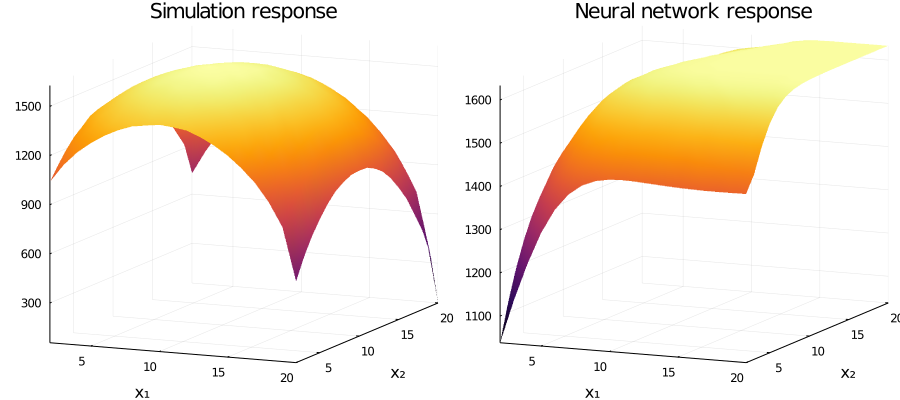

In [51]:
plot(
    surface(
        2:1:20,
        2:1:20,
        (x1, x2) -> simulate(M, x1, x2),
        legend=false,
        title="Simulation response"
    ),
    surface(
            2:1:20,
            2:1:20,
            (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
            legend=false,
            title="Neural network response"
    ),
    size=(900, 400),
    xlabel="x₁", ylabel="x₂"
)

In [52]:
simulate(M, 11, 11)

1616.002

In [24]:
X_extended = []
y_extended = []
@time for j=2:2:20, k=2:2:20
    gain = simulate(M, j, k)
    push!(X_extended, [j, k])
    push!(y_extended, [gain])
    println("($j, $k) = $(gain)")
end

(2, 2) = 1037.3787
(2, 4) = 1195.4477
(2, 6) = 1295.6498
(2, 8) = 1361.4357
(2, 10) = 1375.8066
(2, 12) = 1356.6349
(2, 14) = 1285.4294
(2, 16) = 1183.202
(2, 18) = 1024.3271
(2, 20) = 730.1261
(4, 2) = 1231.9023
(4, 4) = 1351.9606
(4, 6) = 1431.624
(4, 8) = 1481.039
(4, 10) = 1499.3138
(4, 12) = 1477.0845
(4, 14) = 1425.8899
(4, 16) = 1339.0597
(4, 18) = 1215.0287
(4, 20) = 991.3436
(6, 2) = 1354.4449
(6, 4) = 1449.369
(6, 6) = 1518.076
(6, 8) = 1563.7782
(6, 10) = 1570.4596
(6, 12) = 1555.7105
(6, 14) = 1507.3733
(6, 16) = 1439.189
(6, 18) = 1337.3438
(6, 20) = 1141.8778
(8, 2) = 1418.9841
(8, 4) = 1505.1449
(8, 6) = 1566.3444
(8, 8) = 1600.9355
(8, 10) = 1615.6158
(8, 12) = 1599.4653
(8, 14) = 1555.3778
(8, 16) = 1491.0519
(8, 18) = 1402.2743
(8, 20) = 1238.5764
(10, 2) = 1439.7887
(10, 4) = 1521.2266
(10, 6) = 1578.9772
(10, 8) = 1618.364
(10, 10) = 1629.3679
(10, 12) = 1609.9869
(10, 14) = 1573.8437
(10, 16) = 1510.9556
(10, 18) = 1424.0981
(10, 20) = 1260.1909
(12, 2) = 1415.2116

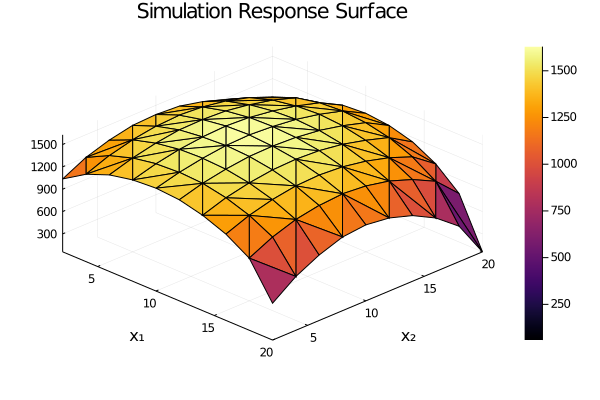

In [25]:
surface([x[1] for x in X_extended], [x[2] for x in X_extended], [y_[1] for y_ in y_extended], title="Simulation Response Surface", xlabel="x₁", ylabel="x₂", margin=5Plots.mm, camera=(45,65))

In [55]:
X_extended[argmax(y_extended)]

2-element Array{Int64,1}:
 10
 10